<h1 style="font-family:Impact,Arial;font-size:30px;">37005 Fundamental of Derivative Security Pricing - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:20px;">Group Assignment Part 1</h1>
<p style="font-family:Arial;">Group 1</p>
<ul>
<li>Hayoung Lee</li>
<li>Quoc Thai Tran</li>
<li>Alexis Cullet</li>
<li>Ziqi Zhou</li>
</ul>


# Import package


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

INDEX_LEVEL = 4170.7002
TODAY = pd.to_datetime('2022-03-08')
MATURITY = pd.to_datetime('2026-12-18')

# Import data


In [2]:
def data_preprocessing():
    df = pd.read_excel("spx_quotedata20220308_all.xlsx")
    df.drop(
        columns=[
            "Last Sale",
            "Calls",
            "Net",
            "IV",
            "Delta",
            "Gamma",
            "Open Interest",
            "Puts",
            "Last Sale.1",
            "Net.1",
            "IV.1",
            "Delta.1",
            "Gamma.1",
            "Open Interest.1",
        ],
        inplace=True,
    )
    df.rename(
        columns={
            "Bid": "Call Bid",
            "Ask": "Call Ask",
            "Volume": "Call Volume",
            "Bid.1": "Put Bid",
            "Ask.1": "Put Ask",
            "Volume.1": "Put Volume",
        },
        inplace=True,
    )
    df["Expiration Date"] = pd.to_datetime(df["Expiration Date"], format="%a %b %d %Y")
    df["Call Price"] = (df["Call Bid"] + df["Call Ask"]) / 2
    df["Put Price"] = (df["Put Bid"] + df["Put Ask"]) / 2
    df.sort_values(by=["Expiration Date", "Strike"], ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    columns = df.columns.tolist()
    return df[
        columns[:2] + ["Call Price"] + columns[2:6] + ["Put Price"] + columns[6:-2]
    ]


data_processed = data_preprocessing()
data_processed

,Expiration Date,Call Bid,Call Price,Call Ask,Call Volume,Strike,Put Bid,Put Price,Put Ask,Put Volume
0,2022-03-09,1151.7,1160.30,1168.9,0,3000,0.0,0.025,0.05,6
1,2022-03-09,951.7,960.40,969.1,0,3200,0.0,0.025,0.05,4
2,2022-03-09,851.2,860.25,869.3,0,3300,0.0,0.025,0.05,2182
3,2022-03-09,751.7,760.40,769.1,0,3400,0.0,0.025,0.05,360
4,2022-03-09,651.2,660.30,669.4,0,3500,0.0,0.025,0.05,1264
...,...,...,...,...,...,...,...,...,...,...
5886,2026-12-18,34.3,74.30,114.3,0,7200,2602.4,2698.400,2794.40,80
5887,2026-12-18,0.0,150.00,300.0,0,8000,3299.5,3395.500,3491.50,3
5888,2026-12-18,0.0,150.00,300.0,0,8600,3832.4,3928.400,4024.40,5
5889,2026-12-18,0.0,150.00,300.0,0,9000,4190.1,4286.100,4382.10,2


# Task 1

Task 1 result
     Maturity  Dividend Discount Factor  Zero Coupon Bond
0  2022-03-09                  0.997496          0.999965
1  2022-03-11                  0.997462          1.000079
2  2022-03-14                  0.997263          1.000150
3  2022-03-16                  0.997030          0.999847
4  2022-03-18                  0.996945          0.999927
5  2022-03-21                  0.997252          1.000222
6  2022-03-23                  0.997327          1.000346
7  2022-03-25                  0.996831          0.999867
8  2022-03-28                  0.996913          0.999969
9  2022-03-30                  0.996952          1.000063
10 2022-03-31                  0.996890          1.000010
11 2022-04-01                  0.996910          1.000076
12 2022-04-04                  0.996823          0.999953
13 2022-04-06                  0.997161          1.000491
14 2022-04-08                  0.996610          1.000066
15 2022-04-14                  0.996567          1.000017


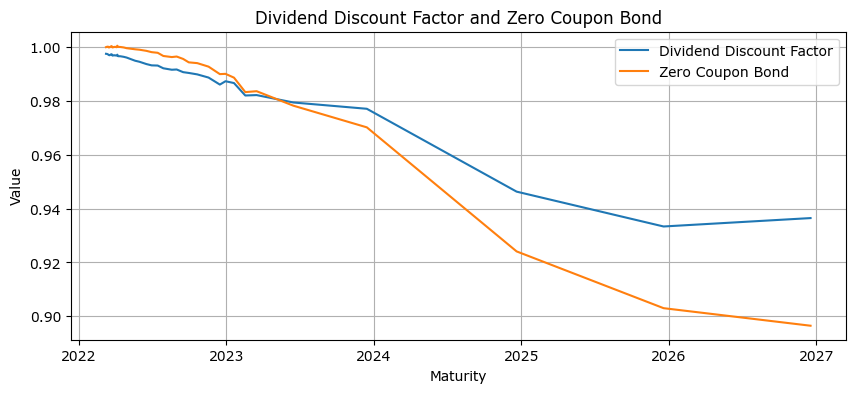

In [3]:
def task_1(stock):
    df = data_processed.copy()
    maturity = list(set(df["Expiration Date"]))
    dividend = []
    discount_factor = []
    for date in maturity:
        data = df[df["Expiration Date"] == date]
        strike = data["Strike"].to_numpy()
        call = data["Call Price"].to_numpy()
        put = data["Put Price"].to_numpy()

        def target_minimizer(x):
            calc = x[0] * stock - x[1] * strike - (call - put)
            return np.sum(np.power(calc - np.mean(calc), 2))

        result = minimize(
            target_minimizer,
            np.ones(2),
            constraints={
                "type": "eq",
                "fun": lambda x: np.sum(x[0] * stock - x[1] * strike - (call - put)),
            },
        ).x
        dividend.append(result[0])
        discount_factor.append(result[1])
    information = pd.DataFrame(
        {
            "Maturity": pd.to_datetime(maturity),
            "Dividend Discount Factor": dividend,
            "Zero Coupon Bond": discount_factor,
        }
    )
    information.sort_values(by=["Maturity"], ascending=True, inplace=True)
    information.reset_index(drop=True, inplace=True)
    return information


task_1_df = task_1(INDEX_LEVEL)
print("Task 1 result")
print(task_1_df)
plt.figure(figsize=(10, 4))
plt.plot(
    task_1_df["Maturity"],
    task_1_df["Dividend Discount Factor"],
    label="Dividend Discount Factor",
)
plt.plot(task_1_df["Maturity"], task_1_df["Zero Coupon Bond"], label="Zero Coupon Bond")
plt.xlabel("Maturity")
plt.ylabel("Value")
plt.grid()
plt.title("Dividend Discount Factor and Zero Coupon Bond")
plt.legend()
plt.show()

# Task 2

Negative Volatility Detected: Maturity: 2022-08-31 00:00:00 Type: Bid => Set to previous value:  0.26039029315491835
Negative Volatility Detected: Maturity: 2022-09-30 00:00:00 Type: Bid => Set to previous value:  0.3318401251067233
Negative Volatility Detected: Maturity: 2022-12-30 00:00:00 Type: Bid => Set to previous value:  0.2336100086129915
Negative Volatility Detected: Maturity: 2023-01-20 00:00:00 Type: Ask => Set to previous value:  0.4465175941958699
Negative Volatility Detected: Maturity: 2023-02-17 00:00:00 Type: Bid => Set to previous value:  0.3325796624075029
Task 2 result
     Maturity  Bid Implied Volatility  Ask Implied Volatility
0  2022-03-09                0.341898                0.413275
1  2022-03-11                0.336409                0.351895
2  2022-03-14                0.275448                0.236758
3  2022-03-16                0.398176                0.400603
4  2022-03-18                0.287762                0.382516
5  2022-03-21                0.27

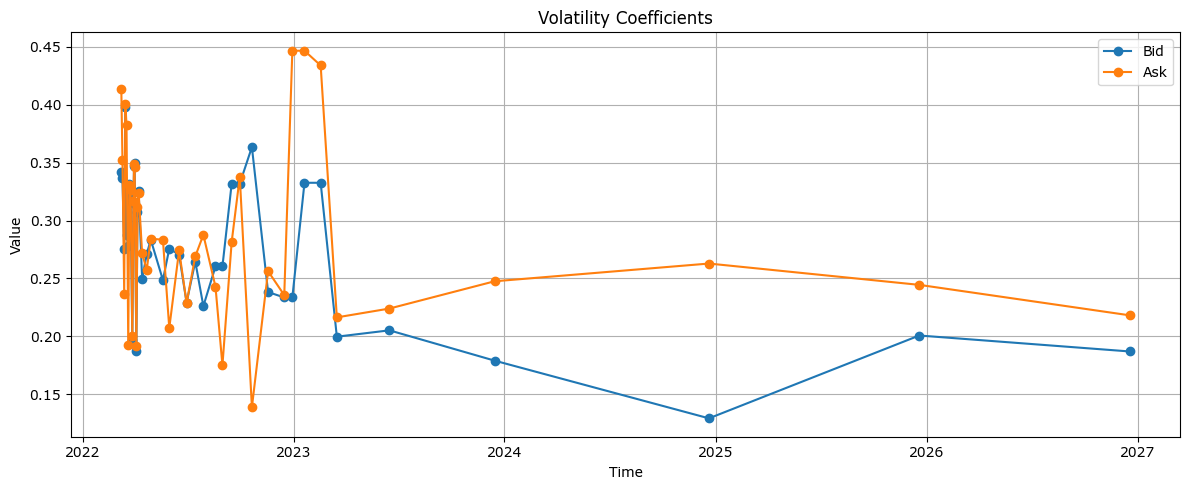

In [4]:
def task_2(stock, noti=None):
    data = data_processed.copy()
    dfs = task_1_df.copy()
    today = TODAY
    vola = [[], []]
    sigma = [[], []]
    for i in range(len(dfs)):
        ext_data = data[data["Expiration Date"] == dfs.iloc[i, 0]].reset_index(
            drop=True
        )
        ext_data["diff"] = np.abs(
            ext_data["Strike"] - stock * dfs.iloc[i, 1] / dfs.iloc[i, 2]
        )
        chosen_data = list(ext_data.loc[ext_data["diff"].idxmin()])[:-1]
        isCall = (
            True
            if chosen_data[3] - chosen_data[1] > chosen_data[8] - chosen_data[6]
            else False
        )

        def solver(x, type):
            d1 = (
                np.log(stock / chosen_data[5])
                - np.log(dfs.iloc[i, 2] / dfs.iloc[i, 1])
                + 0.5 * x
            ) / (np.sqrt(x))
            d2 = d1 - np.sqrt(x)
            if isCall:
                return (
                    stock * dfs.iloc[i, 1] * norm.cdf(d1)
                    - chosen_data[5] * dfs.iloc[i, 2] * norm.cdf(d2)
                    - chosen_data[1 if type == "bid" else 3]
                )
            else:
                return (
                    chosen_data[5] * dfs.iloc[i, 2] * norm.cdf(-d2)
                    - stock * dfs.iloc[i, 1] * norm.cdf(-d1)
                    - chosen_data[6 if type == "bid" else 8]
                )

        vola[0].append(fsolve(solver, 0.001, args=("bid"))[0])
        vola[1].append(fsolve(solver, 0.001, args=("ask"))[0])
    sum_vola = pd.DataFrame(
        {
            "Maturity": dfs["Maturity"],
            "Bid Implied Volatility": vola[0],
            "Ask Implied Volatility": vola[1],
        }
    )
    vola[0] = np.concatenate(([vola[0][0]], np.diff(vola[0])))
    vola[1] = np.concatenate(([vola[1][0]], np.diff(vola[1])))
    for i in range(len(dfs)):
        delta_t = (
            (dfs.iloc[i, 0] - today).days
            / ((today + pd.DateOffset(years=1)) - today).days
            if i == 0
            else (dfs.iloc[i, 0] - dfs.iloc[i - 1, 0]).days
            / ((dfs.iloc[i - 1, 0] + pd.DateOffset(years=1)) - dfs.iloc[i - 1, 0]).days
        )
        for j in range(2):
            if vola[j][i] < 0:
                if noti is not None:
                    print(
                        "Negative Volatility Detected: Maturity:",
                        dfs.iloc[i, 0],
                        "Type:",
                        "Bid" if j == 0 else "Ask",
                        ". Set to previous value: ",
                        sigma[j][-1],
                    )
                sigma[j].append(sigma[j][-1])
            else:
                sigma[j].append(np.sqrt(vola[j][i] / delta_t))
    return (
        pd.DataFrame(
            {
                "Maturity": dfs["Maturity"],
                "Bid Implied Volatility": sigma[0],
                "Ask Implied Volatility": sigma[1],
            }
        ),
        sum_vola,
    )


task_2_df, sum_volatility = task_2(INDEX_LEVEL)
print("Task 2 result")
print(task_2_df)
plt.figure(figsize=(12, 5))
plt.plot(
    task_2_df["Maturity"], task_2_df["Bid Implied Volatility"], label="Bid", marker="o"
)
plt.plot(
    task_2_df["Maturity"], task_2_df["Ask Implied Volatility"], label="Ask", marker="o"
)
plt.title("Volatility Coefficients")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Task 4

before # "Fair" guarantee level g --> Value of the contract calculated by volatility with bid price = Value of the contract calculated by volatility with ask price  

now # "Fair" guarantee level g --> S(0) = value of the contract using implied ask volatility

It means that the option's price matches the client's investment

ith sum_vol : $\sigma_i^2 (T_i - T_{i-1})$

sum of implied ask volatility : $\sum_{i=1}^{n}\sigma_i^2 (T_i - T_{i-1})$

In [5]:
def year_transform(today, date):
    runner = today
    days = (date - runner).days
    year = 0
    while days > 0:
        next_runner = runner + pd.DateOffset(years=1)
        if days > (next_runner - runner).days:
            year += 1
            days -= (next_runner - runner).days
        else:
            year += days / (next_runner - runner).days
            days -= days
        runner = next_runner
    return year

In [6]:
def guarantee(stock, alpha, initial_value, sum_vola):
    dfs = task_1_df.copy()
    today = TODAY
    maturity = MATURITY
    D_0T = dfs[dfs["Maturity"] == maturity].iloc[0, 1]
    B_0T = dfs[dfs["Maturity"] == maturity].iloc[0, 2]
    TimeToMat = year_transform(today, maturity)

    def solver(g):
        h1_ask = (
            g * TimeToMat / (1 - alpha) - np.log(D_0T / B_0T) + 1 / 2 * sum_vola
        ) / np.sqrt(sum_vola)
        h2_ask = (
            -g * TimeToMat / (1 - alpha)
            + np.log(D_0T / B_0T)
            + (1 / 2 - alpha) * sum_vola
        ) / np.sqrt(sum_vola)
        Val_ask = B_0T * (
            stock * np.exp(g * TimeToMat) * norm.cdf(h1_ask)
            + stock
            * ((D_0T / B_0T) ** (1 - alpha))
            * np.exp((alpha**2 - alpha) / 2 * sum_vola)
            * norm.cdf(h2_ask)
        )
        return stock - Val_ask

    return fsolve(solver, initial_value)[0]


_, sum_vola = task_2(INDEX_LEVEL)

guarantees = [
    (
        alpha,
        guarantee(
            INDEX_LEVEL,
            alpha,
            0.05,
            sum_vola[sum_vola["Maturity"] == MATURITY].iloc[0, 2],
        ),
    )
    for alpha in [0.25, 0.5, 0.75]
]

for couple in guarantees:
    print(f"Alpha a: {couple[0]},", f"Guarantee g: {couple[1]}")

Alpha a: 0.25, Guarantee g: -0.02027644662804652
Alpha a: 0.5, Guarantee g: 0.00540243001096912
Alpha a: 0.75, Guarantee g: 0.019758362741833485


In [13]:
def Monte_Carlo(couple):
    [alpha, g] = couple
    today = TODAY
    maturity = MATURITY
    dfs = task_1_df.copy()
    D_0T = dfs[dfs['Maturity']==maturity].iloc[0,1] 
    B_0T = dfs[dfs['Maturity']==maturity].iloc[0,2]
    vol = sum_vola[sum_vola['Maturity']==MATURITY].iloc[0,2]
    TimeToMat = year_transform(today, maturity)
    w = np.random.standard_normal(1000000)
    ST = INDEX_LEVEL*(D_0T/B_0T)*np.exp(-0.5*vol+np.sqrt(vol)*w)
    payoff = np.maximum(INDEX_LEVEL*np.exp(g*TimeToMat),(INDEX_LEVEL**(alpha))*(ST**(1-alpha)))
    return B_0T*np.mean(payoff)
for couple in guarantees:
    print(f"Alpha a: {couple[0]},",f"Guarantee g: {couple[1]}", f"Monte Carlo: {Monte_Carlo(couple)}")

Alpha a: 0.25, Guarantee g: -0.02027644662804652 Monte Carlo: 4170.21433132493
Alpha a: 0.5, Guarantee g: 0.00540243001096912 Monte Carlo: 4170.628541624314
Alpha a: 0.75, Guarantee g: 0.019758362741833485 Monte Carlo: 4170.628427083274


# Task 5

--------------------------------------------------Alpha a: 0.25, Guarantee g: -0.02027644662804652--------------------------------------------------
Optimizer status: Optimization terminated successfully
Hedging Cost: 4261.109570168528
Smallest Different: 0.0026327199079787533
Position: [ 6.34892870e-05  1.04433520e-01  5.33955372e-01  1.10933990e-05
 -7.35187246e-07  1.26608336e-05 -4.24400957e-04 -5.29175636e-07
  2.58460613e-07  2.58440111e-07  2.58426753e-07 -4.39806472e-02
  2.28213817e-06  6.32472243e-02  1.22648832e-06  2.61434815e-06
  8.14518436e-05 -3.51012360e-06 -6.32392187e-02 -2.66152475e-05
 -5.39083132e-05 -1.16644698e-05  1.05581991e-06 -1.32428492e-06
  4.00074963e+03]
Adjusted Hedging Cost: 4261.107209951389
Adjusted Smallest Different: 0.0
Adjusted Position: [ 6.34892870e-05  1.04433520e-01  5.33955372e-01  1.10933990e-05
 -7.35187246e-07  1.26608336e-05 -4.24400957e-04 -5.29175636e-07
  2.58460613e-07  2.58440111e-07  2.58426753e-07 -4.39806472e-02
  2.28213817e-06

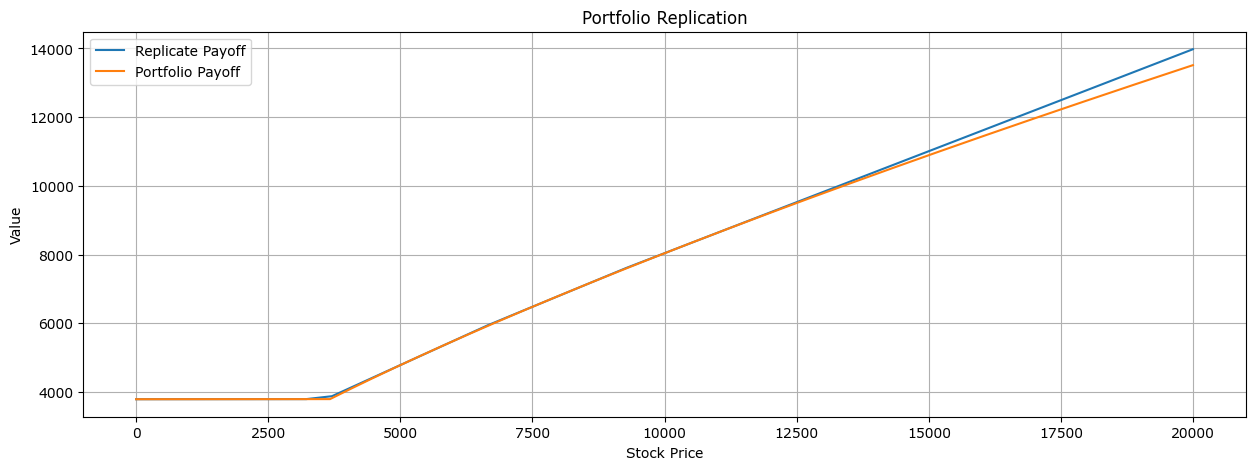

----------Payoff Graph after adjusted----------


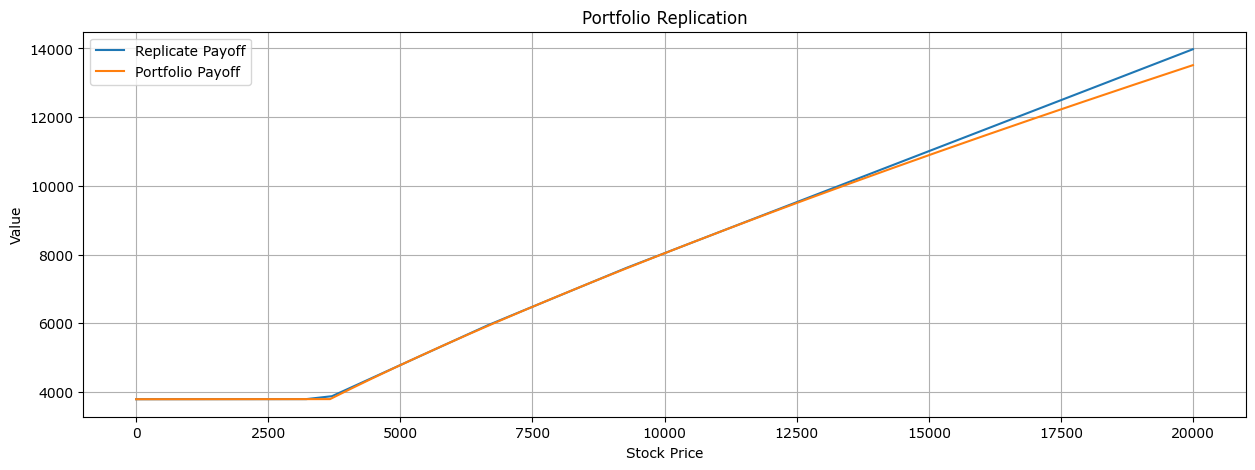

--------------------------------------------------Alpha a: 0.5, Guarantee g: 0.00540243001096912--------------------------------------------------
Optimizer status: Optimization terminated successfully
Hedging Cost: 4200.756953544581
Smallest Different: 0.49825122112451936
Position: [ 5.35192298e-05  8.08934164e-07  4.02597856e-04  2.71154313e-02
  1.57282281e-01  4.29150745e-02  3.62426262e-03  4.37351758e-02
  1.78904480e-06  1.62157109e-06  1.62157149e-06 -1.89136536e-06
 -2.35401123e-05  2.22551582e-05  2.58656234e-06  3.52406472e-04
  1.89378833e-01 -1.92380441e-04 -5.96216167e-05 -2.21216145e-05
 -8.42175000e-05 -1.84537754e-01 -4.43400494e-03 -2.80962406e-04
  5.11559999e+03]
Adjusted Hedging Cost: 4200.310274401968
Adjusted Smallest Different: 0.0
Adjusted Position: [ 5.35192298e-05  8.08934164e-07  4.02597856e-04  2.71154313e-02
  1.57282281e-01  4.29150745e-02  3.62426262e-03  4.37351758e-02
  1.78904480e-06  1.62157109e-06  1.62157149e-06 -1.89136536e-06
 -2.35401123e-05  2.

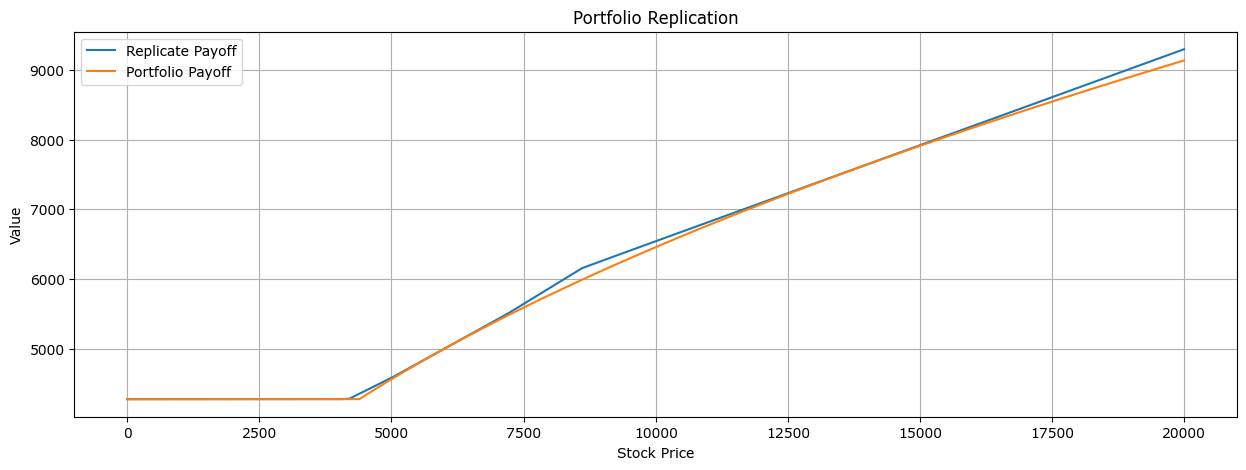

----------Payoff Graph after adjusted----------


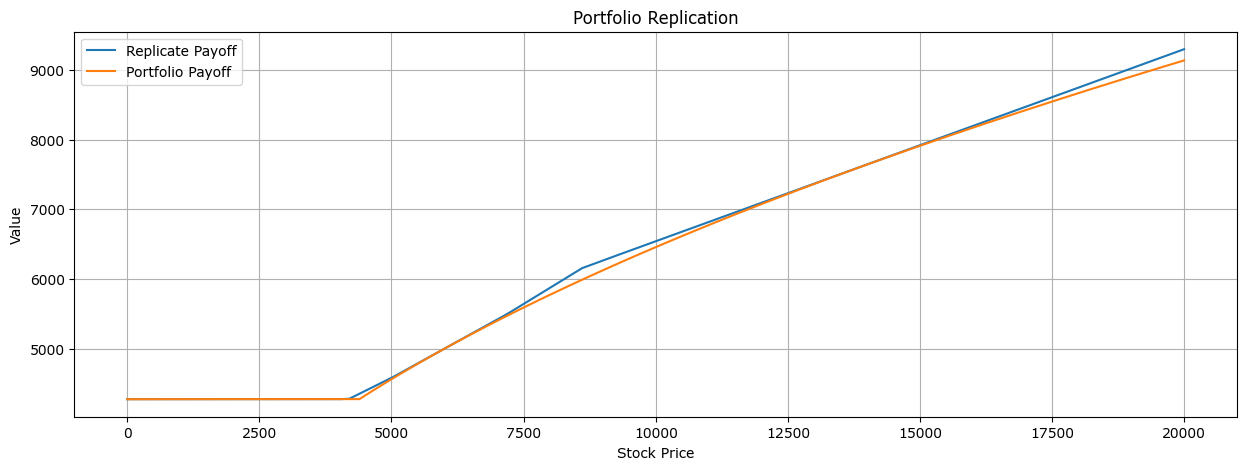

--------------------------------------------------Alpha a: 0.75, Guarantee g: 0.019758362741833485--------------------------------------------------
Optimizer status: Optimization terminated successfully
Hedging Cost: 4192.781920823901
Smallest Different: 0.09223862894941703
Position: [ 8.93409716e-02 -3.03019150e-03  1.14118224e-06 -3.04648736e-05
 -2.29141288e-05  5.96543376e-02  1.08280075e-01 -7.72163792e-06
  2.29920484e-06  1.81606998e-06  1.65063457e-06 -1.39029715e-01
 -8.74035459e-02 -7.47514163e-05  6.31598085e-04 -1.77963702e-04
  2.66020979e-05  1.30388433e-03  4.31193706e-06 -5.93597261e-07
  3.54414657e-06  5.55111215e-03  1.89286309e-06  8.01441055e-02
  4.00058585e+03]
Adjusted Hedging Cost: 4192.6992294627
Adjusted Smallest Different: 0.0
Adjusted Position: [ 8.93409716e-02 -3.03019150e-03  1.14118224e-06 -3.04648736e-05
 -2.29141288e-05  5.96543376e-02  1.08280075e-01 -7.72163792e-06
  2.29920484e-06  1.81606998e-06  1.65063457e-06 -1.39029715e-01
 -8.74035459e-02 -7.

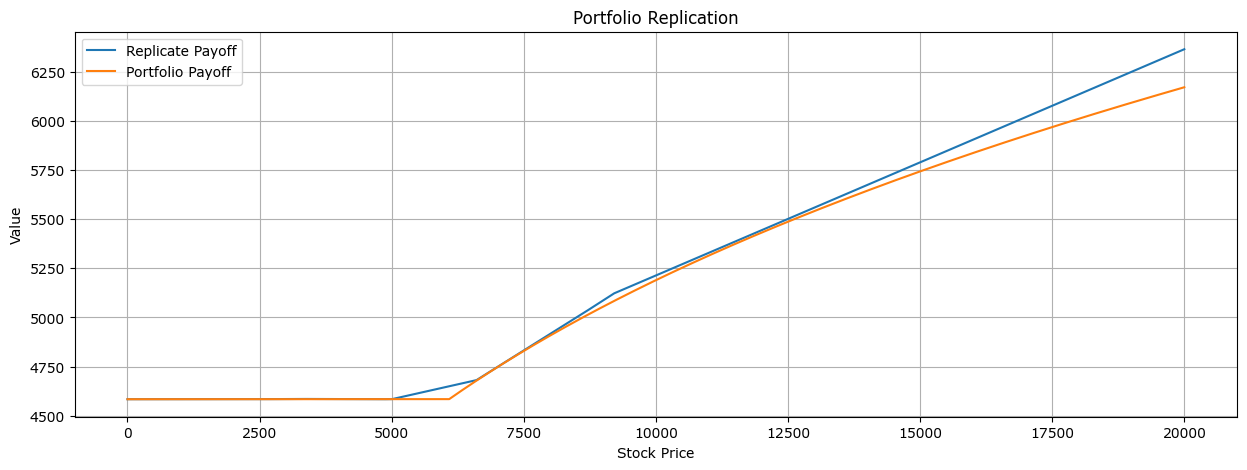

----------Payoff Graph after adjusted----------


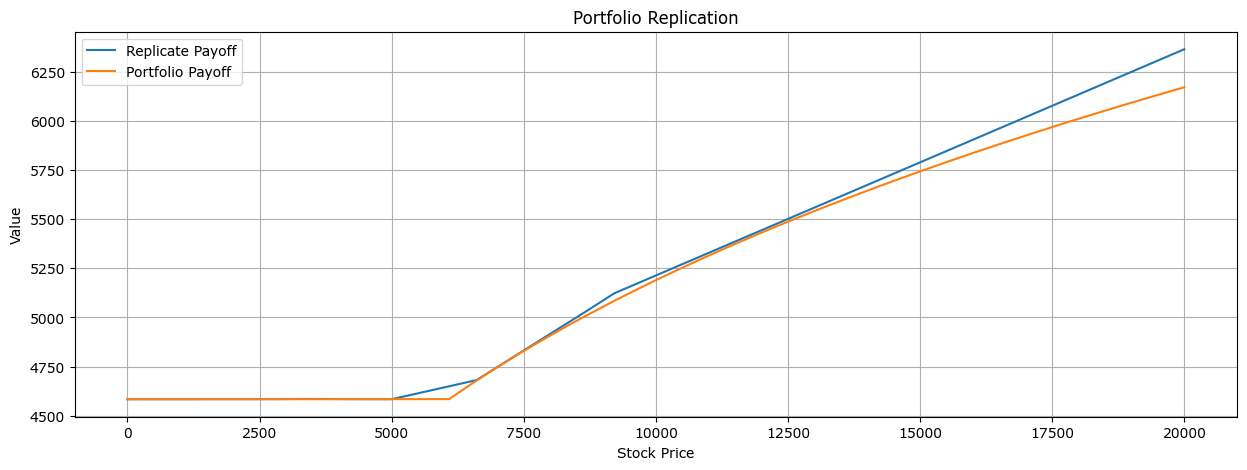

In [7]:
def task_5(guarantee):
    alpha = guarantee[0]
    g = guarantee[1]
    filter_data = data_processed[
        data_processed["Expiration Date"] == MATURITY
    ].reset_index(drop=True)
    filter_data.sort_values(by=["Strike"], ascending=True, inplace=True)
    filter_data.reset_index(drop=True, inplace=True)
    price = [
        list(filter_data["Call Bid"].to_numpy()),
        list(filter_data["Call Ask"].to_numpy()),
    ]
    price[0].extend(list(filter_data["Put Bid"].to_numpy()))
    price[1].extend(list(filter_data["Put Ask"].to_numpy()))
    strike = filter_data["Strike"].to_numpy()
    time_to_maturity = year_transform(TODAY, MATURITY)
    B_0T = task_1_df[task_1_df["Maturity"] == MATURITY].iloc[0, 2]

    def replicate_payoff(x, position):
        call_position = position[:12]
        put_position = position[12:24]
        return (
            np.sum(call_position * np.maximum(x - strike, 0))
            + position[-1]
            + np.sum(put_position * np.maximum(strike - x, 0))
        )

    def portfolio_payoff(x):
        return max(
            INDEX_LEVEL * np.exp(g * time_to_maturity),
            (INDEX_LEVEL**alpha) * ((x if x > 0 else 0) ** (1 - alpha)),
        )

    def payoff_diff(x, position):
        position = np.array(position)
        return replicate_payoff(x, position) - portfolio_payoff(x)

    def value(x):
        x_value = np.array(x)[:-1]
        pos = np.sign(x_value)
        calc_price = [
            price[1][i] if pos[i] == 1 else price[0][i] for i in range(len(price[0]))
        ]
        calc_price = np.array(calc_price)
        val = np.sum(x_value * calc_price) + x[-1] * B_0T
        return val

    def smallest_diff(position, step=10):
        position = np.array(position)
        diff = list(map(lambda x: payoff_diff(x, position), np.arange(0, 20000, step)))
        return np.array(diff)

    positions = None
    smallest = None
    for _ in range(10):
        if positions is not None:
            positions.x[-1] -= smallest
        positions = minimize(
            value,
            [1] * (24) + [4000] if positions is None else positions.x,
            constraints={"type": "ineq", "fun": smallest_diff},
            bounds=[(-np.inf, np.inf) for _ in range(8)]
            + [(0, np.inf) for _ in range(3)]
            + [(-np.inf, np.inf) for _ in range(14)],
            options={"maxiter": 1000},
        )
        smallest_point = minimize(payoff_diff, 0, args=(np.array(positions.x))).x
        smallest = payoff_diff(smallest_point, np.array(positions.x))
        if positions.success:
            print("Optimizer status:", positions.message)
            break
    positions = positions.x

    def plot(smaller, bigger, position=positions):
        position = np.array(position)
        S = np.arange(smaller, bigger, 1)
        plt.figure(figsize=(15, 5))
        plt.plot(
            S,
            list(map(lambda x: replicate_payoff(x, position), S)),
            label="Replicate Payoff",
        )
        plt.plot(
            S, list(map(lambda x: portfolio_payoff(x), S)), label="Portfolio Payoff"
        )
        plt.xlabel("Stock Price")
        plt.ylabel("Value")
        plt.title("Portfolio Replication")
        plt.legend()
        plt.grid()
        plt.show()

    return value(positions), positions, plot, smallest_diff, value, payoff_diff


for g in guarantees:
    print(
        f"--------------------------------------------------Alpha a: {g[0]}, Guarantee g: {g[1]}--------------------------------------------------"
    )
    value, position, plot, smallest_diff, cost_cal, payoff_diff = task_5(g)
    print("Hedging Cost:", value)
    print(
        "Smallest Different:",
        payoff_diff(minimize(payoff_diff, 0, args=(np.array(position))).x, position),
    )
    print("Position:", position)
    test_positions = np.array(position)
    test_positions[-1] -= payoff_diff(
        minimize(payoff_diff, 0, args=(np.array(position))).x, position
    )
    print("Adjusted Hedging Cost:", cost_cal(test_positions))
    print(
        "Adjusted Smallest Different:",
        payoff_diff(
            minimize(payoff_diff, 0, args=(np.array(test_positions))).x, test_positions
        ),
    )
    print("Adjusted Position:", test_positions)
    print("----------Payoff Graph before adjusted----------")
    plot(0, 20000)
    print("----------Payoff Graph after adjusted----------")
    plot(0, 20000, test_positions)